# Load input data

In [1]:
# functions needed for MO-ASMO calibration for one basin
# Gong et al., (2015) Multiobjective adaptive surrogate modeling-based optimization for parameter estimation of large, complex geophysical models, WRR
# https://github.com/gongw03/MO-ASMO

# The Derecho version can run many cases within one node to be efficient, but manual submission is needed

# generate new parameter sets by using MO-ASMO algorithms


import os, sys, subprocess, time, toml
import pandas as pd
from MOASMO_parameters import generate_initial_parameter_sets, surrogate_model_train_and_pareto_points
import run_multiple_paramsets_Derecho

########################################################################################################################
# load configurations

#config_file = '/glade/u/home/guoqiang/CTSM_repos/CTSM_calibration/src/config_templates/_example.MO_ASMO.config_MOASMO.toml'
config_file = '/glade/work/guoqiang/CTSM_CAMELS/Calib_HH_MOASMO/configuration/_level1-0_config_MOASMO.toml'
config = toml.load(config_file)

iter_end = 1

# inputs
file_parameter_list = config['file_calib_param']
path_CTSM_base = config['path_CTSM_case']
path_script_MOASMO = config['path_script_MOASMO']
path_CTSM_source = config['path_CTSM_source']
ref_streamflow = config['file_Qobs']

if 'add_flow_file' in config:
    add_flow_file = config['add_flow_file']
else:
    add_flow_file = 'NA'

script_singlerun = f'{path_script_MOASMO}/run_one_paramset_Derecho.py'
script_clone = f'{path_CTSM_source}/cime/scripts/create_clone'


# outputs
if config['path_calib'] == 'NA':
    path_MOASMOcalib = f'{path_CTSM_base}_MOASMOcalib'
else:
    path_MOASMOcalib = config['path_calib']
    
path_paramset = f'{path_MOASMOcalib}/param_sets'
path_submit = f'{path_MOASMOcalib}/run_model'
path_archive = f'{path_MOASMOcalib}/ctsm_outputs'
os.makedirs(path_MOASMOcalib, exist_ok=True)


# MO-ASMO parameters
sampling_method = config['sampling_method']
num_init = config['num_init'] # initial number of samples
num_per_iter = config['num_per_iter'] # number of selected pareto parameter sets for each iteration
num_iter = config['num_iter'] # including the initial iteration

# evaluation period
RUN_STARTDATE = config['RUN_STARTDATE']
ignore_month = config['ignore_month']
STOP_OPTION = config['STOP_OPTION']
STOP_N = config['STOP_N']

if 'nonstandard_evaluation' in config:
    nonstandard_evaluation = config['nonstandard_evaluation']
else:
    nonstandard_evaluation = 'NA'

# HPC job settings
job_mode = config['job_mode']
job_CTSMiteration = config['job_CTSMiteration']
# job_controlMOASMO = config['job_controlMOASMO'] # not needed here

date_start = (pd.Timestamp(RUN_STARTDATE) + pd.offsets.DateOffset(months=ignore_month)).strftime('%Y-%m-%d') # ignor the first year when evaluating model
if STOP_OPTION == 'nyears':
    date_end = (pd.Timestamp(RUN_STARTDATE) + pd.offsets.DateOffset(years=STOP_N)).strftime('%Y-%m-%d')
elif STOP_OPTION == 'nmonths':
    date_end = (pd.Timestamp(RUN_STARTDATE) + pd.offsets.DateOffset(months=STOP_N)).strftime('%Y-%m-%d')
else:
    sys.exit(f'STOP_OPTION must be nyears or nmonths. {STOP_OPTION} is not accepted.')

########################################################################################################################
# MO-ASMO main

file_metric_all = []
file_param_all = []

t1 = time.time()
for it in range(0, iter_end):
    print('#'*50)
    print(f'Start iterattion {it}. Total iteration number: {num_iter}')
    

    iterflag = it

    if it == 0:
        sample_num = num_init
    else:
        sample_num = num_per_iter

    file_metric_iter, file_param_iter = run_multiple_paramsets_Derecho.check_if_all_runs_are_finsihed(path_archive, iterflag, sample_num)
    file_metric_all.append(file_metric_iter)
    file_param_all.append(file_param_iter)

# train a surrogate model and select pareto parameter sets
surrogate_model_train_and_pareto_points(file_parameter_list, file_param_all, file_metric_all, path_paramset, iterflag, num_per_iter, path_CTSM_base)

# generate submission commands (note, this won't submit a real job on Derecho)
run_multiple_paramsets_Derecho.generate_and_submit_multi_CTSM_runs(iter_end, path_submit, path_paramset, path_CTSM_base, 
                                                                   path_archive, script_singlerun, script_clone, 
                                                                   date_start, date_end, ref_streamflow, add_flow_file,
                                                                   job_CTSMiteration, job_mode)


t2 = time.time()
print(f'Iteration {it} is complete. Time cost (s) is {t2 - t1}')

########################################################################################################################
# Main loop: running following trials


##################################################
Start iterattion 0. Total iteration number: 16
Mean KGE Score: 0.8449021254293367
Load default parameter values from: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO/level1_0_MOASMOcalib/param_sets/all_default_parameters.pkl
Generating parameter file: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO/level1_0_MOASMOcalib/param_sets/paramset_iter1_trial0.pkl
Generating parameter file: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO/level1_0_MOASMOcalib/param_sets/paramset_iter1_trial1.pkl
Generating parameter file: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO/level1_0_MOASMOcalib/param_sets/paramset_iter1_trial2.pkl
Generating parameter file: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO/level1_0_MOASMOcalib/param_sets/paramset_iter1_trial3.pkl
Generating parameter file: /glade/campaign/cgd/tss/people/guoqiang/

In [2]:
        from MOASMO_parameters import *
        param_infofile, param_filelist, metric_filelist, outpath, iterflag, num_per_iter, path_CTSM_case = file_parameter_list, file_param_all, file_metric_all, path_paramset, iterflag, num_per_iter, path_CTSM_base

        # input data x (parameter sets) and output data y (objective function values)
        df_param = pd.concat(map(pd.read_csv, param_filelist))
        df_metric = pd.concat(map(pd.read_csv, metric_filelist))
        df_info = read_parameter_csv(param_infofile)

        param_names = df_info['Parameter'].values # exclude binded parameters
        df_param = df_param[param_names]

        xlb_mean = np.array([np.nanmean(v) for v in df_info['Lower']])
        xub_mean = np.array([np.nanmean(v) for v in df_info['Upper']])

        x = df_param.to_numpy()
        y = df_metric.to_numpy()

        ind = ~np.isnan( np.sum(x,axis=1) + np.sum(y,axis=1))
        x, y = x[ind, :], y[ind, :]

# MO-ASMO GPR

In [3]:

    # path_CTSM_case must be provided if there are any binded parameters for calibration
    
    # check whether files have been generated
    flag = False
    for i in range(num_per_iter):
        outfile = f'{outpath}/paramset_iter{iterflag+1}_trial{i}.csv'
        if not os.path.isfile(outfile):
            flag = True
            break
            
    if flag == False:
        print('All parameter csv files have been generated. Skip this step')
    else:
        # define hyper parameters
        pop = 100
        gen = 100
        crossover_rate = 0.9
        mu = 20
        mum = 20

        # define hyperparameter
        alpha = 1e-3
        leng_lb = 1e-3
        leng_ub = 1e3
        nu = 2.5

        n_sample = num_per_iter # number of selected optimal points

        nInput = x.shape[1]
        nOutput = y.shape[1]

        # train the surrogate model
        #### GPR method
        # https://github.com/NCAR/ctsm_optz/blob/89e3689e73180574c62d1f5aa555a57e886a7cec/workflow/scripts/MOASMO_onestep.pe_basin.py#LL311C1-L315C41
        sm = gp.GPR_Matern(x, y, nInput, nOutput, x.shape[0], xlb_mean, xub_mean, alpha=alpha, leng_sb=[leng_lb, leng_ub], nu=nu)
        os.makedirs(outpath, exist_ok=True)
        sm_filename = f'{outpath}/surrogate_model_for_iter{iterflag}'
        pickle.dump(sm, open(sm_filename, 'wb'))


        # # cross-validation to obtain the accuracy of the emulator
        # kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
        # kge_scores = []
        
        # for train_index, test_index in kf.split(x):
        #     x_train, x_test = x[train_index], x[test_index]
        #     y_train, y_test = y[train_index], y[test_index]
            
        #     # Initialize and train your GPR model here; adjust parameters as needed
        #     # (length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
        #     # sm = gp.GPR_Matern(x_train, y_train, nInput, nOutput, x_train.shape[1], xlb_mean, xub_mean, alpha=1e-10, leng_sb=[0.1, 10], nu=1.5)
        #     sm = gp.GPR_Matern(x_train, y_train, nInput, nOutput, x_train.shape[0], xlb_mean, xub_mean, alpha=alpha, leng_sb=[leng_lb, leng_ub], nu=nu)
        #     # sm = gp.GPR_Matern(x_train, y_train, nInput, nOutput, x_train.shape[0], xlb_mean, xub_mean)
            
        #     # Predict using the trained model
        #     y_pred = sm.predict(x_test)  # Adjust this method call based on your model's API
            
        #     # Evaluate the model using KGE
        #     kge_score = [get_modified_KGE(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
        #     kge_scores.append(np.mean(kge_score))
        
        # # Calculate the mean KGE score across all folds
        # mean_kge_score = np.nanmean(kge_scores)
        # print("Mean KGE Score:", mean_kge_score)

        
        # # Convert the list of KGE scores into a pandas DataFrame
        # kge_scores_df = pd.DataFrame({'Fold': range(1, len(kge_scores) + 1), 'KGE_Score': kge_scores})
        # mean_score_df = pd.DataFrame({'Fold': ['Mean'], 'KGE_Score': [mean_kge_score]})
        # kge_scores_df = pd.concat([kge_scores_df, mean_score_df], ignore_index=True)
        # csv_file_path =  f'{outpath}/surrogate_model_for_iter{iterflag}_CV_kge.csv'
        # # kge_scores_df.to_csv(csv_file_path, index=False)
        
        # # #### GPR method

        # print(kge_scores_df)

In [4]:
        bestx_sm, besty_sm, x_sm, y_sm = NSGA2.optimization(sm, nInput, nOutput, xlb_mean, xub_mean, pop, gen, crossover_rate, mu, mum)
        D = NSGA2.crowding_distance(besty_sm)
        idxr = D.argsort()[::-1][:n_sample]
        x_resample = bestx_sm[idxr, :]
        y_resample = besty_sm[idxr, :]

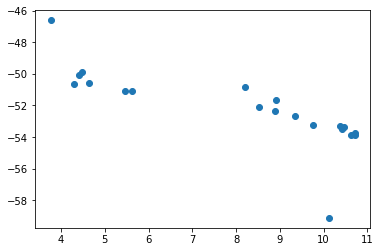

In [6]:
import matplotlib.pyplot as plt
plt.scatter(y_resample[:,0], y_resample[:,1])

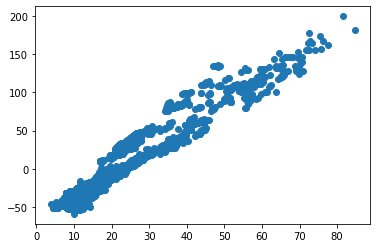

In [7]:
plt.scatter(y_sm[:,0], y_sm[:,1])

In [ ]:
plt.scatter(y[:,0], y[:,1])

# Sklearn 
MinMaxScaler for each CV batch

In [78]:
# sklean using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern
from sklearn.model_selection import KFold
import numpy as np


def train_and_evaluate_with_predictions_gpr(params, metrics_use):
    print('Processing...')

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    kge_scores = []  # To store the KGE score for each fold

    # Define the kernel with Matern function
    kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)

    # Initialize the GPR model
    model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True, random_state=42)

    for train_idx, test_idx in cv.split(params):
        X_train, X_test = params[train_idx], params[test_idx]
        y_train, y_test = metrics_use[train_idx], metrics_use[test_idx]

        # Normalize features
        scaler = MinMaxScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    
        model.fit(X_train_scaled, y_train)  # Fit the model on the training data
        y_pred = model.predict(X_test_scaled)  # Predict on the test set

        if y_pred.ndim==1:
            y_pred = y_pred[:,np.newaxis]
    
        # Calculate KGE for each column (target) and take the mean
        fold_kge_scores = [get_modified_KGE(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
        fold_mean_kge = np.nanmean(fold_kge_scores)  # Compute the mean KGE score for this fold, ignoring any NaN values
        kge_scores.append(fold_mean_kge)
    
    
    mean_kge_score = np.mean(kge_scores)  # Calculate the mean KGE score across all folds
    
    return mean_kge_score

# Execute the function with your data
mean_kge_score_gpr = train_and_evaluate_with_predictions_gpr(x, y)
print('Mean KGE score for GPR:', mean_kge_score_gpr)

Processing...
Mean KGE score for GPR: 0.7538556554164657


# Sklearn
minmax using xlb and xub before CV

In [13]:
# sklean using self defined minmax

from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern
from sklearn.model_selection import KFold
import numpy as np


def train_and_evaluate_with_predictions_gpr(params, metrics_use):
    print('Processing...')

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    kge_scores = []  # To store the KGE score for each fold

    # Define the kernel with Matern function
    kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)

    # Initialize the GPR model
    model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True, random_state=42)

    for train_idx, test_idx in cv.split(params):
        X_train, X_test = params[train_idx], params[test_idx]
        y_train, y_test = metrics_use[train_idx], metrics_use[test_idx]

        # Normalize features
        X_train_scaled = X_train
        X_test_scaled = X_test
    
        model.fit(X_train_scaled, y_train)  # Fit the model on the training data
        y_pred = model.predict(X_test_scaled)  # Predict on the test set

        if y_pred.ndim==1:
            y_pred = y_pred[:,np.newaxis]
    
        # Calculate KGE for each column (target) and take the mean
        fold_kge_scores = [get_modified_KGE(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
        fold_mean_kge = np.nanmean(fold_kge_scores)  # Compute the mean KGE score for this fold, ignoring any NaN values
        kge_scores.append(fold_mean_kge)
    
    
    mean_kge_score = np.mean(kge_scores)  # Calculate the mean KGE score across all folds
    
    return mean_kge_score

# Execute the function with your data
x_scaled = (x - xlb_mean) / (xub_mean - xlb_mean)

mean_kge_score_gpr = train_and_evaluate_with_predictions_gpr(x_scaled, y[:, 1][:, np.newaxis])
print('Mean KGE score for GPR:', mean_kge_score_gpr)

Processing...
Mean KGE score for GPR: 0.6781306958730251
